# Sungyoung Internal Validation Study

## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\ode-biomarker-project


In [2]:
from PathLoader import PathLoader
path_loader = PathLoader('data_config.env', 'current_user.env')
from DataLink import DataLink
data_link = DataLink(path_loader, 'data_codes.csv')

print('Loading data..')

loading_code = 'ccle-gdsc-2-Palbociclib-LN_IC50'
feature_data, label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code}')

Loading data..
Data loaded for code ccle-gdsc-2-Palbociclib-LN_IC50


## SY's Valiadtion Method for Curse of Dimensionality

### Setup

In [3]:
## Loading Data 

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

X, y = make_regression(n_samples=1000, n_informative=50, n_features=1000, noise=0.1)
# make X,y into dataframes
X = pd.DataFrame(X)
y = pd.Series(y)

In [4]:
### Functions 

def log_distributed_feature_size_list(min_size,max_size):
    # log distributed feature size list
    feature_size_list = []
    # first, find the which tenth power the min_size and max_size are
    min_power = int(np.log10(min_size))
    max_power = int(np.log10(max_size))
    # print(f'min_power: {min_power}, max_power: {max_power}')
    for power in range(min_power,max_power+1):
        for i in range(1,10):
            feature_size = i*10**power
            if feature_size <= max_size:
                feature_size_list.append(feature_size)
    return feature_size_list

def generate_feature_list(feature_data, feature_size):
    features = feature_data.columns
    feature_list = []
    # randomly select feature_size number of features
    for i in range(feature_size):
        while True:
            # ensure that the same feature is not selected twice
            feature = np.random.choice(features)
            if feature not in feature_list:
                feature_list.append(feature)
                break
            
    return feature_list

In [5]:
### Global Parameters 

no_random_partitions = 100 
partitition_seed = 23
# set the random seed for the partitions
np.random.seed(partitition_seed)
partition_random_seed_list = list(np.random.randint(0,1000000,no_random_partitions))
features_random_seed = 42
feature_sizes = log_distributed_feature_size_list(1,X.shape[1])
feature_list = generate_feature_list(X, X.shape[1])

## File Parameters 
run_id = 'run_1'
project_folder_name = 'SYVALID'
folder_name = "AN01_curse_of_dimensionality"
if not os.path.exists(f'{path_loader.get_data_path()}data/results/{project_folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{project_folder_name}')
    
if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{project_folder_name}/{folder_name}/'

In [6]:
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from toolkit import *

def pipeline_func(X_train, y_train, rng, feature_data, label_data, pre_selected_features, feature_size, max_iter, **kwargs):
    # NOTE: X_train, y_train are not used in this function

    model = LinearSVR(max_iter=max_iter, random_state=rng)
    # print(f'Feature size: {feature_size}')
    if feature_size == feature_data.shape[1]:
        selected_features = feature_data.columns
        X_selected = feature_data
    else:
        selected_features = pre_selected_features[:feature_size]
        X_selected = feature_data[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, label_data, test_size=0.2, random_state=rng)
    # print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
    model.fit(X_train, y_train)
    # print('Model fitted')
    return {'model': model,
            'selected_features': selected_features,
            'feature_size': feature_size,
            'X_test': X_test,
            'y_test': y_test
            }
    
def eval_func(X_test, y_test, pipeline_components=None, save_model=False, **kwargs):
    
    # NOTE: override the X_test, y_test with the ones from pipeline_components
    X_test = pipeline_components['X_test']
    y_test = pipeline_components['y_test']
    # print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # print(f'y_pred shape: {y_pred.shape}')
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)

    # print(f'Correlation: {corr}')
    returned_data = {'model_performance': corr, 
                     'feature_importance': None, ### DO NOT GET RID 
                     'p_vals': p_vals,
                     'selected_features': selected_features,
                     'feature_size' : pipeline_components['feature_size']
    }
    if save_model:
        returned_data['model'] = pipeline_components['model']
    return returned_data

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Performance Debugging

Performance Debugging revealed the LinearSVR is substantially faster than SVR with the linear kernal (both implemented by sklearn)

In [29]:
model = LinearSVR(max_iter=10000)
feature_size = X.shape[1]
feature_data = X
label_data = y
print(f'Feature size: {feature_size}')
if feature_size == feature_data.shape[1]:
    selected_features = feature_data.columns
    X_selected = feature_data
    print(f'All features selected')
else:
    selected_features = feature_list[:feature_size]
    X_selected = feature_data[selected_features]
    print(f'Randomly selected features')
X_train, X_test, y_train, y_test = train_test_split(X_selected, label_data, test_size=0.2, random_state=1)
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
model.fit(X_train, y_train)
print('Model fitted')

selected_features, X_selected = select_preset_features(X_test, y_test, selected_features)
y_pred = model.predict(X_selected)
print(f'y_pred shape: {y_pred.shape}')
# assess performance by pearson correlation
corr, p_vals = pearsonr(y_test, y_pred)

print(f'Correlation: {corr}')

Feature size: 1000
All features selected
X_train shape: (800, 1000), X_test shape: (200, 1000)
Model fitted
y_pred shape: (200,)
Correlation: 0.8802356431179759


### Running on Mock Data

In [7]:
powerkit = Powerkit(X,y)

# add conditions based on feature size 

for feature_size in feature_sizes:
    powerkit.add_condition(str(feature_size), False, 
                           pipeline_func, 
                           {
                            "feature_data": X,
                            "label_data": y,
                            "pre_selected_features": feature_list, 
                            "feature_size": feature_size,
                            "max_iter": 10000
                           },
                           eval_func, 
                           {}
                           )

In [8]:
from tqdm import tqdm

all_dfs = []
for feature_size in tqdm(feature_sizes):
    df = powerkit.run_selected_condition(str(feature_size), partition_random_seed_list, 1, False)
    all_dfs.append(df)
    
final_df = pd.concat(all_dfs)

100%|██████████| 28/28 [01:32<00:00,  3.32s/it]


In [9]:
final_df.reset_index(inplace=True)

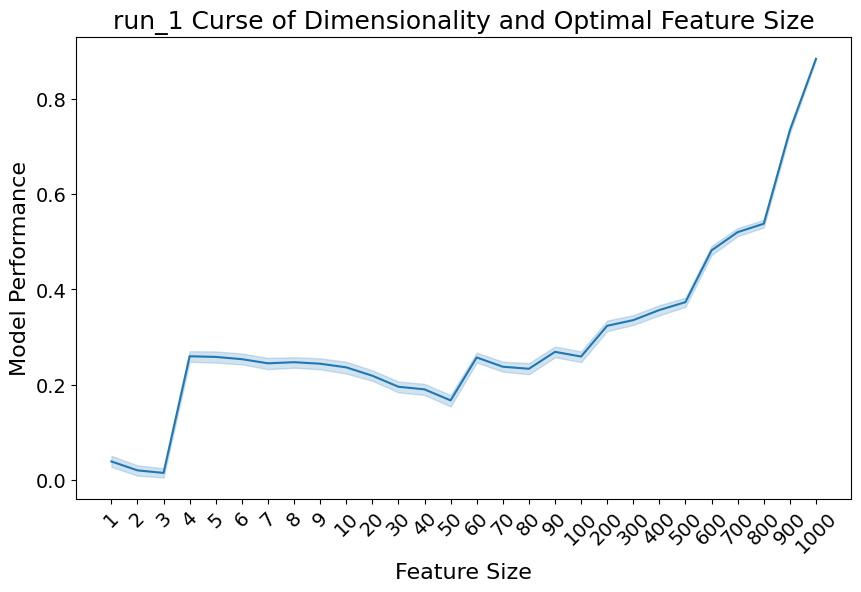

In [18]:
# import seaborn 

import seaborn as sns
import matplotlib.pyplot as plt

# change plot size 
plt.figure(figsize=(10,6))
sns.lineplot(data=final_df, x='condition', y='model_performance')
plt.title(f'{run_id} Curse of Dimensionality and Optimal Feature Size', fontsize=18)
# xlabel and ylabel, increase font size1
plt.xlabel('Feature Size', fontsize=16)
plt.ylabel('Model Performance', fontsize=16)
# rotate x-axis labels
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()



## SY's Rudimentary Pipeline Logic

Whole data --> Preprocessing --> Feature Selection --> Splitting --> Fitting

This is a fundamentally different process from the current Powerkit protocol. 

In [4]:
print('Selecting the top 100 features in the data')

from toolkit import *

selected_features, scores = f_regression_select(feature_data, label_data, k=100)

Selecting the top 100 features in the data


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
from sklearn.svm import SVR

model = SVR(kernel='linear')
selected_features, X_selected = select_preset_features(feature_data, label_data, selected_features)

In [6]:
# split the data into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, label_data, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
print('Model trained')

Model trained


In [7]:
# make predictions

y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
# pearson correlation from scipy 
from scipy.stats import pearsonr

mse = mean_squared_error(y_test, y_pred)
pearson_corr, p_vals = pearsonr(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Pearson Correlation: {pearson_corr}, p-value: {p_vals}')




Mean Squared Error: 2.3432940622273413
Pearson Correlation: 0.4649029418773342, p-value: 1.2870656256712425e-07


In [12]:
### Greedy Forward Select, but without resetting the model and report the internal validation scores 

print('Greedy Forward Selecting the top 20 features in the data')

start_feature = selected_features[0]

selected_features, scores, model = greedy_feedforward_select_sy(X_selected, label_data,
                                                                k=20, 
                                                                model=model, 
                                                                start_feature=start_feature, 
                                                                cv=5,
                                                                verbose=1)



Greedy Forward Selecting the top 20 features in the data
Feature Selected: RPL3, Score: 0.552636050749855, Feature Size: 2
Feature Selected: PPIC, Score: 0.5927602111000807, Feature Size: 3
Feature Selected: SETDB2, Score: 0.6098624819706714, Feature Size: 4
Feature Selected: BAIAP2, Score: 0.6223589576710935, Feature Size: 5
Feature Selected: TUFT1, Score: 0.6289724594011268, Feature Size: 6
Feature Selected: SNX21, Score: 0.6389793248636391, Feature Size: 7
Feature Selected: GMFG, Score: 0.6397582885947983, Feature Size: 8
Feature Selected: ITGAL, Score: 0.6400193045732537, Feature Size: 9
Feature Selected: NCKAP1, Score: 0.642028397388853, Feature Size: 10
Feature Selected: TESPA1, Score: 0.6439144344847202, Feature Size: 11
Feature Selected: SLC49A4, Score: 0.6441354794630852, Feature Size: 12
Feature Selected: ITGB5, Score: 0.6494810956678634, Feature Size: 13
Feature Selected: SNX24, Score: 0.6512696720556639, Feature Size: 14
Feature Selected: TNFRSF12A, Score: 0.653100735175852